In [1]:
import os
import cv2
import progressbar
from time import sleep
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

device_name = tf.test.gpu_device_name()

if len(device_name) > 0:
    print('Found GPU at: {}', format(device_name))
else:
    device_name = '/device:CPU:0'
    print('No GPU, using {}', format(device_name))

Found GPU at: {} /device:GPU:0


converting all radiograph images from rgb to grayscale

In [ ]:
# image_names = os.listdir('dataset/Radiographs/')

# bar = progressbar.ProgressBar(maxval=len(image_names), \
#     widgets=[progressbar.Bar('#', 'Converting Images to Grayscale: [', ']', '-'), ' ', progressbar.Percentage()])
# bar.start()

# for idx, img_name in enumerate(image_names):
#     img_path = os.path.join('dataset/Radiographs/', img_name)
#     image = cv2.imread(img_path)
#     grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     cv2.imwrite(img_path, grayscale_image)
#     bar.update(idx+1)

# bar.finish()

In [2]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                validation_split = 0.2,
                                                               )
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)


batch_size = 8
target_size = (512, 512)
train_image_generator = image_datagen.flow_from_directory(
    './dataset/new_direc',
    target_size = target_size,
    class_mode = None,
    classes = ['images'],
    color_mode = 'grayscale',
    batch_size = batch_size,
    seed = 42,
    subset = 'training',
    shuffle=False,
    
)

train_mask_generator = mask_datagen.flow_from_directory(
    './dataset/new_direc',
    target_size = target_size,
    class_mode = None,
    classes = ['masks'],
    color_mode = 'grayscale',
    batch_size = batch_size,
    seed = 42,
    subset = 'training',
    shuffle=False,
)

val_image_generator = image_datagen.flow_from_directory(
    './dataset/new_direc',
    target_size = target_size,
    class_mode = None,
    classes = ['images'],
    color_mode = 'grayscale',
    batch_size = batch_size,
    seed = 42,
    subset = 'validation',
    shuffle=False,
)

val_mask_generator = mask_datagen.flow_from_directory(
    './dataset/new_direc',
    target_size = target_size,
    class_mode = None,
    classes = ['masks'],
    color_mode = 'grayscale',
    batch_size = batch_size,
    seed = 42,
    subset = 'validation',
    shuffle=False,
)

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 3200 images belonging to 1 classes.
Found 3200 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.


In [ ]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

In [ ]:
# count = 400
# X_train = []
# Y_train = []
# image_names = os.listdir('dataset/Radiographs/')

# for img_name in image_names:
#     img_path = os.path.join('dataset/Radiographs/', img_name)
#     mask_path = os.path.join('dataset/Segmentation/teeth_mask', img_name)
#     image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     if image is not None and mask is not None:
#         resized_image = cv2.resize(image, (769, 400), interpolation=cv2.INTER_LINEAR)
#         resized_mask = cv2.resize(mask, (580, 212), interpolation=cv2.INTER_LINEAR)
#         (thresh, im_bw) = cv2.threshold(resized_mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#         X_train.append(resized_image/255)
#         Y_train.append(im_bw/255)
#         count = count - 1
#     if count == 0:
#         break
# X_train = np.float32(np.array(X_train))
# Y_train = np.float32(np.array(Y_train))
# # Y_train = tf.one_hot(Y_train, 2)

In [ ]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

def jaccard_distance_loss(y_true, y_pred,smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [ ]:
# Y_train[0].shape

In [ ]:
with tf.device(device_name):
    def buildModel(base_neuron_count, input_shape):
        inputs = layers.Input(shape=input_shape)

        c0 = layers.Conv2D(base_neuron_count, activation='relu', kernel_size=3, name="c0")(inputs) # size would be (838, 1613, 64)
        c1 = layers.Conv2D(base_neuron_count, activation='relu', kernel_size=3, name="c1")(c0) #(835, 1611, 64)

        c2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name="c2")(c1)
        c3 = layers.Conv2D(2*base_neuron_count, activation='relu', kernel_size=3, name="c3")(c2)
        c4 = layers.Conv2D(2*base_neuron_count, activation='relu', kernel_size=3, name="c4")(c3)

        c5 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name="c5")(c4)
        c6 = layers.Conv2D(4*base_neuron_count, activation='relu', kernel_size=3, name="c6")(c5)
        c7 = layers.Conv2D(4*base_neuron_count, activation='relu', kernel_size=3, name="c7")(c6)

        c8 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name="c8")(c7)
        c9 = layers.Conv2D(8*base_neuron_count, activation='relu', kernel_size=3, name="c9")(c8)
        c10 = layers.Conv2D(8*base_neuron_count, activation='relu', kernel_size=3, name="c10")(c9)

        c11 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name="c11")(c10)
        c12 = layers.Conv2D(16*base_neuron_count, activation='relu', kernel_size=3, name="c12")(c11)
        c13 = layers.Conv2D(16*base_neuron_count, activation='relu', kernel_size=3, name="c13")(c12)

        t01 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu', name="t01")(c13)
        crop01 = layers.Cropping2D(cropping=((4, 4), (4, 4)), name="crop01")(c10)
        concat01 = layers.concatenate([t01, crop01], axis=-1, name="concat01")
        c14 = layers.Conv2D(8*base_neuron_count, activation='relu', kernel_size=3, name="c14")(concat01)
        c15 = layers.Conv2D(8*base_neuron_count, activation='relu', kernel_size=3, name="c15")(c14)

        t02 = layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu', name="t02")(c15)
        crop02 = layers.Cropping2D(cropping=((17, 16), (17, 16)), name="crop02")(c7)
        concat02 = layers.concatenate([t02, crop02], axis=-1, name="concat02")
        c16 = layers.Conv2D(4*base_neuron_count, activation='relu', kernel_size=3, name="c16")(concat02)
        c17 = layers.Conv2D(4*base_neuron_count, activation='relu', kernel_size=3, name="c17")(c16)

        t03 = layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu', name="t03")(c17)
        crop03 = layers.Cropping2D(cropping=((41, 41), (41, 41)), name="crop03")(c4)
        concat03 = layers.concatenate([t03, crop03], axis=-1, name="concat03")
        c18 = layers.Conv2D(2*base_neuron_count, activation='relu', kernel_size=3, name="c18")(concat03)
        c19 = layers.Conv2D(2*base_neuron_count, activation='relu', kernel_size=3, name="c19")(c18)

        t04 = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu', name="t04")(c19)
        crop04 = layers.Cropping2D(cropping=((90, 90), (90, 90)), name="crop04")(c1)
        concat04 = layers.concatenate([t04, crop04], axis=-1, name="concat04")
        c20 = layers.Conv2D(base_neuron_count, activation='relu', kernel_size=3, name="c20")(concat04)
        c21 = layers.Conv2D(base_neuron_count, activation='relu', kernel_size=3, name="c21")(c20)

        outputs = layers.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(c21)
        return keras.Model(inputs = inputs, outputs=outputs, name='U-net')
    unet = buildModel(2, (512, 512, 1))
    unet.summary()
    unet.compile()
    unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=['binary_crossentropy'], metrics=[iou_coef,'accuracy'])

In [ ]:
model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)



training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

history = unet.fit(train_generator,
                    steps_per_epoch=training_samples_size//batch_size,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//batch_size,
                    epochs=10,
                    callbacks = [earlystop, checkpoint]
                  )

In [ ]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred, smooth=1):
    return 1 - dice_coef(y_true, y_pred, smooth)

def IoULoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets*inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return 1 - IoU

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value


#########################################
# Dice similarity coefficient loss, brought to you by: https://github.com/nabsabraham/focal-tversky-unet
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [3]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

with tf.device(device_name):
    def conv_block(input, num_filters):
        x = Conv2D(num_filters, 3, padding="same")(input)
        x = BatchNormalization()(x)   #Not in the original network. 
        x = Activation("relu")(x)

        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)  #Not in the original network
        x = Activation("relu")(x)
        
        return x

    #Encoder block: Conv block followed by maxpooling


    def encoder_block(input, num_filters):
        x = conv_block(input, num_filters)
        p = MaxPool2D((2, 2))(x)
        p = Dropout(0.25)(p)
        return x, p   

    #Decoder block
    #skip features gets input from encoder for concatenation

    def decoder_block(input, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
        x = Concatenate()([x, skip_features])
        x = Dropout(0.25)(x)
        x = conv_block(x, num_filters)
        return x

    #Build Unet using the blocks
    def build_unet(base_num_features, input_shape, n_classes):
        inputs = Input(input_shape)

        s1, p1 = encoder_block(inputs, base_num_features)
        s2, p2 = encoder_block(p1, 2*base_num_features)
        s3, p3 = encoder_block(p2, 4*base_num_features)

        s4, p4 = encoder_block(p3, 8*base_num_features)

        b1 = conv_block(p4, 16*base_num_features) #Bridge
#         b1 = conv_block(p3, 8*base_num_features) #Bridge

        d1 = decoder_block(b1, s4, 8*base_num_features)

        d2 = decoder_block(d1, s3, 4*base_num_features)
#         d2 = decoder_block(b1, s3, 4*base_num_features)
        d3 = decoder_block(d2, s2, 2*base_num_features)
        d4 = decoder_block(d3, s1, base_num_features)

    #     if n_classes == 1:  #Binary
    #       activation = 'sigmoid'
    #     else:
    #       activation = 'softmax'

        outputs = Conv2D(n_classes, 1, activation='sigmoid')(d4)  #Change the activation based on n_classes
    #     print(activation)

        model = Model(inputs, outputs, name="U-Net")
        return model

    unet = build_unet(4, (512, 512, 1), n_classes=1)
    unet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1, 0], threshold=0.4)])
    unet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 4)  40          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 4)  16         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 32, 32, 64)  256         ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 32, 32, 64)   0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 64)   36928       ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 32, 32, 64)  256         ['conv2d_9[0][0]']               
 rmalization)                                                                                     
          

 activation_15 (Activation)     (None, 256, 256, 8)  0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 512, 512, 4)  132        ['activation_15[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_3 (Concatenate)    (None, 512, 512, 8)  0           ['conv2d_transpose_3[0][0]',     
                                                                  'activation_1[0][0]']           
                                                                                                  
 dropout_7 (Dropout)            (None, 512, 512, 8)  0           ['concatenate_3[0][0]']          
                                                                                                  
 conv2d_16

In [4]:
model_path = "image512_bce_iou_4.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)



training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

history = unet.fit(train_generator,
                    steps_per_epoch=training_samples_size//batch_size,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//batch_size,
                    epochs=100,
                    callbacks = [checkpoint, earlystop]
                  )

Epoch 1/100
400/400 [==============================] - ETA: 0s - loss: 0.3968 - binary_io_u: 0.4573
Epoch 00001: val_loss improved from inf to 0.30693, saving model to image512_bce_iou_4.h5
400/400 [==============================] - 131s 308ms/step - loss: 0.3968 - binary_io_u: 0.4573 - val_loss: 0.3069 - val_binary_io_u: 0.5683
Epoch 2/100
400/400 [==============================] - ETA: 0s - loss: 0.1378 - binary_io_u: 0.7813
Epoch 00002: val_loss improved from 0.30693 to 0.13570, saving model to image512_bce_iou_4.h5
400/400 [==============================] - 126s 314ms/step - loss: 0.1378 - binary_io_u: 0.7813 - val_loss: 0.1357 - val_binary_io_u: 0.7901
Epoch 3/100
400/400 [==============================] - ETA: 0s - loss: 0.0922 - binary_io_u: 0.8066
Epoch 00003: val_loss improved from 0.13570 to 0.08616, saving model to image512_bce_iou_4.h5
400/400 [==============================] - 127s 318ms/step - loss: 0.0922 - binary_io_u: 0.8066 - val_loss: 0.0862 - val_binary_io_u: 0.8272

Epoch 27/100
400/400 [==============================] - ETA: 0s - loss: 0.0524 - binary_io_u: 0.8406
Epoch 00027: val_loss did not improve from 0.05497
400/400 [==============================] - 127s 316ms/step - loss: 0.0524 - binary_io_u: 0.8406 - val_loss: 0.0574 - val_binary_io_u: 0.8399
Epoch 28/100
400/400 [==============================] - ETA: 0s - loss: 0.0521 - binary_io_u: 0.8411
Epoch 00028: val_loss did not improve from 0.05497
400/400 [==============================] - 126s 316ms/step - loss: 0.0521 - binary_io_u: 0.8411 - val_loss: 0.0551 - val_binary_io_u: 0.8442
Epoch 29/100
400/400 [==============================] - ETA: 0s - loss: 0.0517 - binary_io_u: 0.8416
Epoch 00029: val_loss did not improve from 0.05497
400/400 [==============================] - 126s 316ms/step - loss: 0.0517 - binary_io_u: 0.8416 - val_loss: 0.0551 - val_binary_io_u: 0.8434
Epoch 30/100
400/400 [==============================] - ETA: 0s - loss: 0.0514 - binary_io_u: 0.8419
Epoch 00030: val_los

Epoch 55/100
400/400 [==============================] - ETA: 0s - loss: 0.0486 - binary_io_u: 0.8459
Epoch 00055: val_loss did not improve from 0.05326
400/400 [==============================] - 129s 323ms/step - loss: 0.0486 - binary_io_u: 0.8459 - val_loss: 0.0534 - val_binary_io_u: 0.8471
Epoch 56/100
400/400 [==============================] - ETA: 0s - loss: 0.0485 - binary_io_u: 0.8459
Epoch 00056: val_loss did not improve from 0.05326
Restoring model weights from the end of the best epoch.
400/400 [==============================] - 129s 324ms/step - loss: 0.0485 - binary_io_u: 0.8459 - val_loss: 0.0536 - val_binary_io_u: 0.8483
Epoch 00056: early stopping


In [ ]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true *y_pred), axis = [1, 2, 3])
    union = K.sum(y_true, [1, 2, 3]) + K.sum(y_pred, [1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [ ]:
n = 0
for i,m in val_generator:
    img,mask = i,m

    if n < 1:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

In [13]:
predicted = unet.predict(val_image_generator, batch_size=32)

100/100 [==============================] - 12s 125ms/step


In [35]:
x = 5
resized_image = cv2.resize(val_image_generator[0][x], (807, 420), interpolation=cv2.INTER_LINEAR)
cv2.imshow('image', resized_image)

resized_mask = cv2.resize(val_mask_generator[0][x], (807, 420), interpolation=cv2.INTER_LINEAR)
cv2.imshow('mask', resized_mask)

resized_predicted = cv2.resize(predicted[x], (807, 420), interpolation=cv2.INTER_LINEAR)
cv2.imshow('predicted', resized_predicted)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
i  = 3

m = tf.keras.metrics.BinaryIoU(target_class_ids = [0, 1], threshold=0.5)
m.update_state(val_mask_generator[0][i], predicted[i])

In [ ]:
m.result().numpy()

In [58]:
np.min(predicted[0])

0.0

In [14]:
predicted[predicted >= 0.5] = 1
predicted[predicted < 0.5] = 0

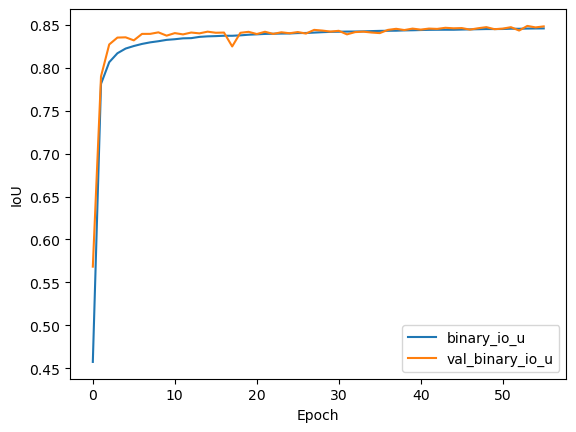

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['binary_io_u'], label='binary_io_u')
plt.plot(history.history['val_binary_io_u'],label='val_binary_io_u')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(loc='lower right')

In [ ]:
import pickle

# with open('newhistory', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)
    
with open('newhistory', "rb") as file_pi:
    history = pickle.load(file_pi)

In [62]:
total_TP = 0
total_TN = 0
total_FP = 0
total_FN = 0

def findTP(msk, p_msk):
    count = 0
    for i in range(512):
        for j in range(512):
            if msk[i][j] == 1 and p_msk[i][j] == 1:
                count = count + 1
                
    return count

def findTN(msk, p_msk):
    count = 0
    for i in range(512):
        for j in range(512):
            if msk[i][j] == 0 and p_msk[i][j] == 0:
                count = count + 1
                
    return count

def findFP(msk, p_msk):
    count = 0
    for i in range(512):
        for j in range(512):
            if msk[i][j] == 0 and p_msk[i][j] == 1:
                count = count + 1
                
    return count

def findFN(msk, p_msk):
    count = 0
    for i in range(512):
        for j in range(512):
            if msk[i][j] == 1 and p_msk[i][j] == 0:
                count = count + 1
                
    return count

for i in range(99):
    for j in range(8):
        img = val_image_generator[i][j]
        mask = val_mask_generator[i][j]
        predicted_mask = predicted[8*i + j]
        
        total_TP = total_TP + findTP(mask, predicted_mask)
        total_TN = total_TN + findTN(mask, predicted_mask)
        total_FP = total_FP + findFP(mask, predicted_mask)
        total_FN = total_FN + findFN(mask, predicted_mask)
        


In [68]:
i = 99
for j in range(8):
    img = val_image_generator[i][j]
    mask = val_mask_generator[i][j]
    predicted_mask = predicted[8*i + j]

    total_TP = total_TP + findTP(mask, predicted_mask)
    total_TN = total_TN + findTN(mask, predicted_mask)
    total_FP = total_FP + findFP(mask, predicted_mask)
    total_FN = total_FN + findFN(mask, predicted_mask)

In [69]:
precision = total_TP/(total_TP + total_FP)
recall = total_TP/(total_TP + total_FN)
f1_score = 2*recall*precision/(recall + precision)

print(precision)
print(recall)
print(f1_score)

0.9560101626923642
0.9345377379457054
0.9451520107944277


In [134]:
print(total_TP)
print(total_TN)
print(total_FP)
print(total_FN)

19187384
180006579
882888
1344033


In [109]:
total = total_TP + total_TN + total_FN + total_FP

In [2]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
plot_confusion_matrix(cm           = np.array([[ total_TP/total,  total_FN/total],
                                              [  total_FP/total,  total_TN/total],]), 
                      normalize    = False,
                      target_names = ['Positive', 'Negative'],
                      title        = "Confusion Matrix")

NameError: name 'total_TP' is not defined

In [130]:
# results = unet.fit(X_train, Y_train, batch_size=4, epochs=100)

In [ ]:
# test_results = unet.evaluate(X_train, Y_test, batch_size=4)

In [ ]:
# predicted = unet.predict(X_train, batch_size=4)

In [ ]:
# predicted[predicted >= 0.2] = 1
# predicted[predicted < 0.2] = 0

In [ ]:
# cv2.imshow('actual', X[10])
cv2.imshow('predicted' ,predicted[6])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# count = 25
# X_test = []
# Y_test = []
# image_names = os.listdir('dataset/Radiographs/')

# for idx, img_name in enumerate(image_names):
#     if idx > 400:
#         img_path = os.path.join('dataset/Radiographs/', img_name)
#         mask_path = os.path.join('dataset/Segmentation/teeth_mask', img_name)
#         image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#         if image is not None and mask is not None:
#             resized_image = cv2.resize(image, (769, 400), interpolation=cv2.INTER_LINEAR)
#             resized_mask = cv2.resize(mask, (580, 212), interpolation=cv2.INTER_LINEAR)
#             (thresh, im_bw) = cv2.threshold(resized_mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#             X_test.append(resized_image/255)
#             Y_test.append(im_bw/255)
#             count = count - 1
#         if count == 0:
#             break
# X_test = np.float32(np.array(X_test))
# Y_test = np.float32(np.array(Y_test))
# # Y_train = tf.one_hot(Y_train, 2)

In [ ]:
# Y_test[0].shape

In [ ]:
# Y_test.shape

In [ ]:
# unet.evaluate(X_test, Y_test, batch_size=4)

In [ ]:
# def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
#     conv = Conv2D(n_filters,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='HeNormal')(inputs)
#     conv = Conv2D(n_filters,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_intializer='HeNormal')(conv)
#     conv = BatchNormalization()(conv, training=False)
    
#     if dropout_prob > 0:
#         conv = tf.keras.layers.Dropout(dropout_prob)(conv)
#     if max_pooling:
#         next_layer = tf.keras.layers.MaxPooling2d(pool_size = (2,2))(conv)
#     else:
#         next_layer = conv
    
#     skip_connection = conv
#     return next_layer, skip_connection

# def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
#     up = Conv2DTranspose(
#                  n_filters,
#                  (3,3),
#                  strides=(2,2),
#                  padding='same')(prev_layer_input)
#     merge = concatenate([up, skip_layer_input], axis=3)
#     conv = Conv2D(n_filters, 
#                  3,  
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='HeNormal')(merge)
#     conv = Conv2D(n_filters,
#                  3, 
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='HeNormal')(conv)
#     return conv

In [ ]:
# def unet_model(inputs):
#     filter_count = 32
#     dl1, skip1 = EncoderMiniBlock(inputs, filter_count)
#     dl2, skip2 = EncoderMiniBlock(dl1, 2*filter_count)
#     dl3, skip3 = EncoderMiniBlock(dl2, 4*filter_count)
#     dl4, skip4 = EncoderMiniBlock(dl3, 8*filter_count)
    
#     ul4 = DecoderMiniBlock(dl4)

In [ ]:
# with tf.device(device_name):
#     model = keras.Model(inputs = input_layer, outputs=output_layer, name='U-net')

In [ ]:
# def build_model(input_layer, start_neurons):
#     conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
#     conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
#     pool1 = layers.MaxPooling2D((2, 2))(conv1)
#     pool1 = layers.Dropout(0.25)(pool1)

#     conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
#     conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
#     pool2 = layers.MaxPooling2D((2, 2))(conv2)
#     pool2 = layers.Dropout(0.5)(pool2)

#     conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
#     conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
#     pool3 = layers.MaxPooling2D((2, 2))(conv3)
#     pool3 = layers.Dropout(0.5)(pool3)

#     conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
#     conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
#     pool4 = layers.MaxPooling2D((2, 2))(conv4)
#     pool4 = layers.Dropout(0.5)(pool4)

#     # Middle
#     convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
#     convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
#     deconv4 = layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
#     uconv4 = layers.concatenate([deconv4, conv4])
#     uconv4 = layers.Dropout(0.5)(uconv4)
#     uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
#     uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

#     deconv3 = layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
#     uconv3 = layers.concatenate([deconv3, conv3])
#     uconv3 = layers.Dropout(0.5)(uconv3)
#     uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
#     uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

#     deconv2 = layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
#     uconv2 = layers.concatenate([deconv2, conv2])
#     uconv2 = layers.Dropout(0.5)(uconv2)
#     uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
#     uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

#     deconv1 = layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
#     uconv1 = layers.concatenate([deconv1, conv1])
#     uconv1 = layers.Dropout(0.5)(uconv1)
#     uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
#     uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
#     output_layer = layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
#     return output_layer

# input_layer = keras.Input((128, 128, 1))
# output_layer = build_model(input_layer, 32)

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#              loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
# results = model.fit(X_train, Y_train, batch_size=32, epochs=20)

In [ ]:
# X_train.shape

In [ ]:
# image_names[0]

In [ ]:
# image = cv2.imread('dataset/Radiographs/' + image_names[0], cv2.IMREAD_GRAYSCALE)

In [ ]:
# image.shape

In [ ]:
# cv2.imshow('resized', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# unet = buildModel(64, (210, 403, 1))
# unet.summary()

In [ ]:
# unet.compile(optimizer=tf.keras.optimizers.Adam(),
#              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# cv2.imshow("tp",Y_train[0])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# # declaring the input layer
# # In the original paper the network consisted of only one channel.
# inputs = layers.Input(shape=(572, 572, 1))
# # first part of the U - contracting part
# c0 = layers.Conv2D(64, activation='relu', kernel_size=3)(inputs)
# c1 = layers.Conv2D(64, activation='relu', kernel_size=3)(c0)  # This layer for concatenating in the expansive part
# c2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c1)

# c3 = layers.Conv2D(128, activation='relu', kernel_size=3)(c2)
# c4 = layers.Conv2D(128, activation='relu', kernel_size=3)(c3)  # This layer for concatenating in the expansive part
# c5 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c4)

# c6 = layers.Conv2D(256, activation='relu', kernel_size=3)(c5)
# c7 = layers.Conv2D(256, activation='relu', kernel_size=3)(c6)  # This layer for concatenating in the expansive part
# c8 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c7)

# c9 = layers.Conv2D(512, activation='relu', kernel_size=3)(c8)
# c10 = layers.Conv2D(512, activation='relu', kernel_size=3)(c9)  # This layer for concatenating in the expansive part
# c11 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c10)

# c12 = layers.Conv2D(1024, activation='relu', kernel_size=3)(c11)
# c13 = layers.Conv2D(1024, activation='relu', kernel_size=3, padding='valid')(c12)

# # We will now start the second part of the U - expansive part
# t01 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(c13)
# crop01 = layers.Cropping2D(cropping=(4, 4))(c10)

# concat01 = layers.concatenate([t01, crop01], axis=-1)

# c14 = layers.Conv2D(512, activation='relu', kernel_size=3)(concat01)
# c15 = layers.Conv2D(512, activation='relu', kernel_size=3)(c14)

# t02 = layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu')(c15)
# crop02 = layers.Cropping2D(cropping=(16, 16))(c7)

# concat02 = layers.concatenate([t02, crop02], axis=-1)

# c16 = layers.Conv2D(256, activation='relu', kernel_size=3)(concat02)
# c17 = layers.Conv2D(256, activation='relu', kernel_size=3)(c16)

# t03 = layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu')(c17)
# crop03 = layers.Cropping2D(cropping=(40, 40))(c4)

# concat03 = layers.concatenate([t03, crop03], axis=-1)

# c18 = layers.Conv2D(128, activation='relu', kernel_size=3)(concat03)
# c19 = layers.Conv2D(128, activation='relu', kernel_size=3)(c18)

# t04 = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu')(c19)
# crop04 = layers.Cropping2D(cropping=(88, 88))(c1)

# concat04 = layers.concatenate([t04, crop04], axis=-1)

# c20 = layers.Conv2D(64, activation='relu', kernel_size=3)(concat04)
# c21 = layers.Conv2D(64, activation='relu', kernel_size=3)(c20)

# outputs = layers.Conv2D(2, kernel_size=1)(c21)

# model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-netmodel")

In [ ]:
# model.summary()

In [ ]:
Y_train[0][0]

In [ ]:
# n_classes = 2

# labels = tf.ones((443, 300), dtype=tf.int32)
# ohe_labels = tf.one_hot(Y_train, n_classes)

In [ ]:
# ohe_labels[0]

In [ ]:
# def cleanName(i):
#     return i.lower()


# direc = './dataset/Radiographs/'
# imgs = os.listdir('./dataset/Radiographs')

# for i in imgs:
#     os.rename(direc + i, direc + cleanName(i))

In [ ]:
# os.listdir('./dataset/Radiographs')